## Challenge - Stock Prediction

![](https://miro.medium.com/max/9216/1*NG0bzk0wtQcBdMYAnXKeBQ.jpeg)
### Background Information


### Get data

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [103]:
data = pd.read_csv('TSLA.csv')

In [104]:
data.shape
data.isna().sum()
data.describe()
#data['Date'] = pd.to_datetime(data['Date'])

(2416, 7)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035003,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


### Preprocessing

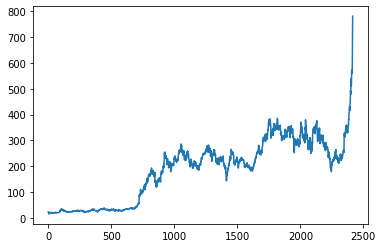

In [105]:
plt.plot(data['Close'])
plt.show()

In [106]:
data['Close']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

data['Close']

0        23.889999
1        23.830000
2        21.959999
3        19.200001
4        16.110001
           ...    
2411    566.900024
2412    580.989990
2413    640.809998
2414    650.570007
2415    780.000000
Name: Close, Length: 2416, dtype: float64

0       0.010586
1       0.010508
2       0.008061
3       0.004449
4       0.000406
          ...   
2411    0.721146
2412    0.739584
2413    0.817862
2414    0.830633
2415    1.000000
Name: Close, Length: 2416, dtype: float64

### Splitting Data

In [107]:

train,test = data[pd.to_datetime(data['Date'])<datetime(2016,1,1)]['Close'],data[pd.to_datetime(data['Date'])>=datetime(2016,1,1)]['Close']
len(train)
len(test)

1388

1028

In [108]:
train

0       0.010586
1       0.010508
2       0.008061
3       0.004449
4       0.000406
          ...   
1383    0.281039
1384    0.278919
1385    0.289702
1386    0.290879
1387    0.293392
Name: Close, Length: 1388, dtype: float64

### Model

In [120]:

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import time

def create_dataset(dataset, look_back=1, forward_days=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-forward_days):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back:i + look_back + forward_days])
    return np.array(dataX), np.array(dataY)

look_back = 40
forward_days = 10
trainX, trainY = create_dataset(train, look_back, forward_days)
testX, testY = create_dataset(test, look_back, forward_days)

# The LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features].
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX

array([[[0.01058623, 0.01050772, 0.00806072, ..., 0.00431824,
         0.00566605, 0.0044491 ]],

       [[0.01050772, 0.00806072, 0.0044491 , ..., 0.00566605,
         0.0044491 , 0.00536509]],

       [[0.00806072, 0.0044491 , 0.00040565, ..., 0.0044491 ,
         0.00536509, 0.0051688 ]],

       ...,

       [[0.26892175, 0.27638052, 0.27780686, ..., 0.27600105,
         0.27312222, 0.27645905]],

       [[0.27638052, 0.27780686, 0.25808689, ..., 0.27312222,
         0.27645905, 0.26330804]],

       [[0.27780686, 0.25808689, 0.25423972, ..., 0.27645905,
         0.26330804, 0.26534939]]])

In [121]:
model = Sequential()

model.add(LSTM(128,
    return_sequences=True,
    activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(
    64,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(forward_days))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='adam')
print ('compilation time : ', time.time() - start)

compilation time :  0.015812158584594727


### Training and Predicting

In [122]:
history = model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=10,
    validation_split=0.05)

Epoch 1/10
10/10 [==============================] - 1s 59ms/step - loss: 0.0250 - val_loss: 0.0462
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0068
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 6.5033e-04
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 6.8773e-04
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 4.5876e-04
Epoch 8/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 5.7179e-04
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 5.0277e-04
Epoch 10/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 5.113

In [123]:
results = model.predict(testX[:4])
results
testY[:4]

array([[0.21870115, 0.2171164 , 0.2161629 , 0.21636918, 0.21700537,
        0.2162019 , 0.2182273 , 0.21779715, 0.22324046, 0.22007525],
       [0.21767381, 0.21592271, 0.21496601, 0.2153234 , 0.21633446,
        0.21510525, 0.21753591, 0.21680206, 0.22239846, 0.21907534],
       [0.21725042, 0.21527618, 0.21428674, 0.21481028, 0.2155748 ,
        0.2148428 , 0.21698165, 0.21613503, 0.22189854, 0.21849671],
       [0.21724492, 0.21532962, 0.21462817, 0.21495733, 0.21611853,
        0.21466164, 0.2169953 , 0.21613397, 0.22193888, 0.2185436 ]],
      dtype=float32)

array([[0.22577859, 0.23546193, 0.24239727, 0.24795864, 0.24443864,
        0.252447  , 0.2478147 , 0.25085056, 0.26086102, 0.26503533],
       [0.23546193, 0.24239727, 0.24795864, 0.24443864, 0.252447  ,
        0.2478147 , 0.25085056, 0.26086102, 0.26503533, 0.26973305],
       [0.24239727, 0.24795864, 0.24443864, 0.252447  , 0.2478147 ,
        0.25085056, 0.26086102, 0.26503533, 0.26973305, 0.27555614],
       [0.24795864, 0.24443864, 0.252447  , 0.2478147 , 0.25085056,
        0.26086102, 0.26503533, 0.26973305, 0.27555614, 0.28387857]])

### Reference:
* https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm
* https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm/data
* https://medium.com/neuronio/predicting-stock-prices-with-lstm-349f5a0974d4